# Creating an Amundsen Sea Low (ASL) index

This work is a continuation of my 2013 and 2016 papers as described [here](https://scotthosking.com/asl_index)

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
from skimage.feature import peak_local_max

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/zespinosa/conda-envs/cenv/share/proj failed


## Definitions

In [2]:
def asl_sector_mean(da, asl_region, mask):
    a = da.where(mask == 0).sel( latitude=slice(asl_region['north'],asl_region['south']), 
                longitude=slice(asl_region['west'],asl_region['east']) ).mean().values
    return a


def get_lows(da, mask):
    '''
    da for one point in time (with lats x lons)
    '''
    
    lons, lats = da.longitude.values, da.latitude.values
    
    sector_mean_pres = asl_sector_mean(da, asl_region, mask)
    threshold = sector_mean_pres

    time_str = str(da.time.values)[:10]
    
    # fill land in with highest value to limit lows being found here
    da_max   = da.max().values
    da       = da.where(mask == 0).fillna(da_max)
        
    invert_data = (da*-1.).values     # search for peaks rather than minima
    
    if threshold is None:
        threshold_abs = invert_data.mean()
    else:
        threshold_abs  = threshold * -1  # define threshold cut-off for peaks (inverted lows)
                
    minima_yx = peak_local_max(invert_data,            # input data
                           min_distance=5,             # peaks are separated by at least min_distance
                           num_peaks=3,                # maximum number of peaks
                           exclude_border=False,       # excludes peaks from within min_distance pixels of the border
                           threshold_abs=threshold_abs # minimum intensity of peaks
                           )
    
    minima_lat, minima_lon, pressure = [], [], []
    for minima in minima_yx:
        minima_lat.append(lats[minima[0]])
        minima_lon.append(lons[minima[1]])
        pressure.append(da.values[minima[0],minima[1]])
    
    df = pd.DataFrame()
    df['lat']        = minima_lat
    df['lon']        = minima_lon
    df['ActCenPres'] = pressure
    df['SectorPres'] = sector_mean_pres
    df['time']       = time_str
    
    ### Add relative central pressure (Hosking et al. 2013)
    df['RelCenPres'] = df['ActCenPres'] - df['SectorPres']

    ### re-order columns
    df = df[['time','lon','lat','ActCenPres','SectorPres','RelCenPres']]
    
    ### clean-up DataFrame
    df = df.reset_index(drop=True)

    return df


def define_asl(df, region):
    ### select only those points within ASL box
    df2 = df[(df['lon'] > region['west'])  & 
                (df['lon'] < region['east'])  & 
                (df['lat'] > region['south']) & 
                (df['lat'] < region['north']) ]

    ### For each time, get the row with the lowest minima_number
    df2 = df2.loc[df2.groupby('time')['ActCenPres'].idxmin()]
    
    df2 = df2.reset_index(drop=True)

    return df2


def slice_region(da, region, boarder=8):
    da = da.sel( latitude=slice(region['north']+boarder,region['south']-boarder), 
                longitude=slice(region['west']-boarder,region['east']+boarder))
    return da

## Read in data

In [6]:
root = '/glade/work/zespinosa/data/index/ASL/amundsen-sea-low-index/data'
da   = xr.open_dataset(os.path.join(root, 'era5_mean_sea_level_pressure_monthly_197901-202312.nc')).msl

root_mask = '/glade/work/zespinosa/GRIDS'
mask = xr.open_dataset(os.path.join(root_mask, 'era5_land_sea_mask_25x25.nc')).lsm.squeeze()
# Rename dim
mask = mask.rename({'lat':'latitude', 'lon':'longitude'})
# Drop coords
mask = mask.reset_coords(names=["realization", "time", "experimentVersionNumber"], drop=True)
# Reset Longitudes
mask["longitude"] = np.concatenate([da["longitude"][720:].values, da["longitude"][:720].values])

In [8]:
da = da.sel(time=np.arange('1979-01-01', '1980-12-01', dtype='datetime64[M]'))

In [9]:
mask

<xarray.DataArray 'lsm' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 180.0 180.2 180.5 180.8 ... 179.2 179.5 179.8
Attributes:
    long_name:      Land-sea mask
    units:          1
    standard_name:  land_area_fraction
    comment:        Fraction of horizontal area occupied by land.
    type:           real
    valid_min:      0.0
    valid_max:      1.0

## Select region and apply land-sea mask

In [10]:
da_mask = da.where(mask == 0)


# region of interest (asl sector)
asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

### slice area around ASL region
da      = slice_region(da, asl_region)
da_mask = slice_region(da_mask, asl_region)

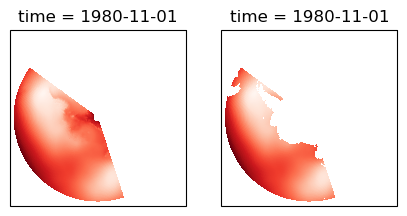

In [11]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot( 121, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax1.set_extent([-180,180,-90,-50], ccrs.PlateCarree())
da.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

ax2 = plt.subplot( 122, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax2.set_extent([-180,180,-90,-50], ccrs.PlateCarree())
da_mask.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

## Loop through each time and identify lows

In [12]:
# change units
da = da / 100. 
da = da.assign_attrs(units='hPa')

ntime        = da.time.shape[0]
all_lows_dfs = pd.DataFrame()

for t in range(0,ntime):
    da_t         = da.isel(time=t)
    all_lows_df  = get_lows(da_t, mask)
    all_lows_dfs = pd.concat([all_lows_dfs, all_lows_df], ignore_index=True)

asl_df = define_asl(all_lows_dfs, asl_region)

In [13]:
asl_df

,time,lon,lat,ActCenPres,SectorPres,RelCenPres
0,1979-01-01,220.25,-68.25,982.861389,986.140564,-3.279175
1,1979-02-01,195.75,-71.50,973.644226,982.676758,-9.032532
2,1979-03-01,223.50,-69.75,972.363098,980.151489,-7.788391
3,1979-04-01,270.00,-67.50,967.868286,979.048035,-11.179749
4,1979-05-01,190.25,-70.50,977.978271,987.411682,-9.433411
5,1979-06-01,213.50,-70.50,968.614136,978.656677,-10.042542
6,1979-07-01,212.00,-74.75,973.735718,980.767395,-7.031677
7,1979-08-01,256.50,-72.00,972.255005,987.389587,-15.134583
8,1979-09-01,207.00,-74.75,973.641479,982.259155,-8.617676
9,1979-10-01,251.25,-72.00,972.795715,982.636536,-9.840820


## Plotting: location of minimas in pressure field

In [14]:
def draw_regional_box( region, transform=None ):
    '''
    Draw box around a region on a map
    region is a dictionary with west,east,south,north
    '''

    if transform == None:
        transform = ccrs.PlateCarree()

    plt.plot([region['west'], region['west']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    plt.plot([region['east'], region['east']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    
    for i in range( np.int(region['west']),np.int(region['east']) ): 
        plt.plot([i,i+1], [region['south'],region['south']], 'k-', transform=transform, linewidth=1)
        plt.plot([i,i+1], [region['north'],region['north']], 'k-', transform=transform, linewidth=1)

/glade/scratch/zespinosa/ipykernel_58600/2720305547.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range( np.int(region['west']),np.int(region['east']) ):


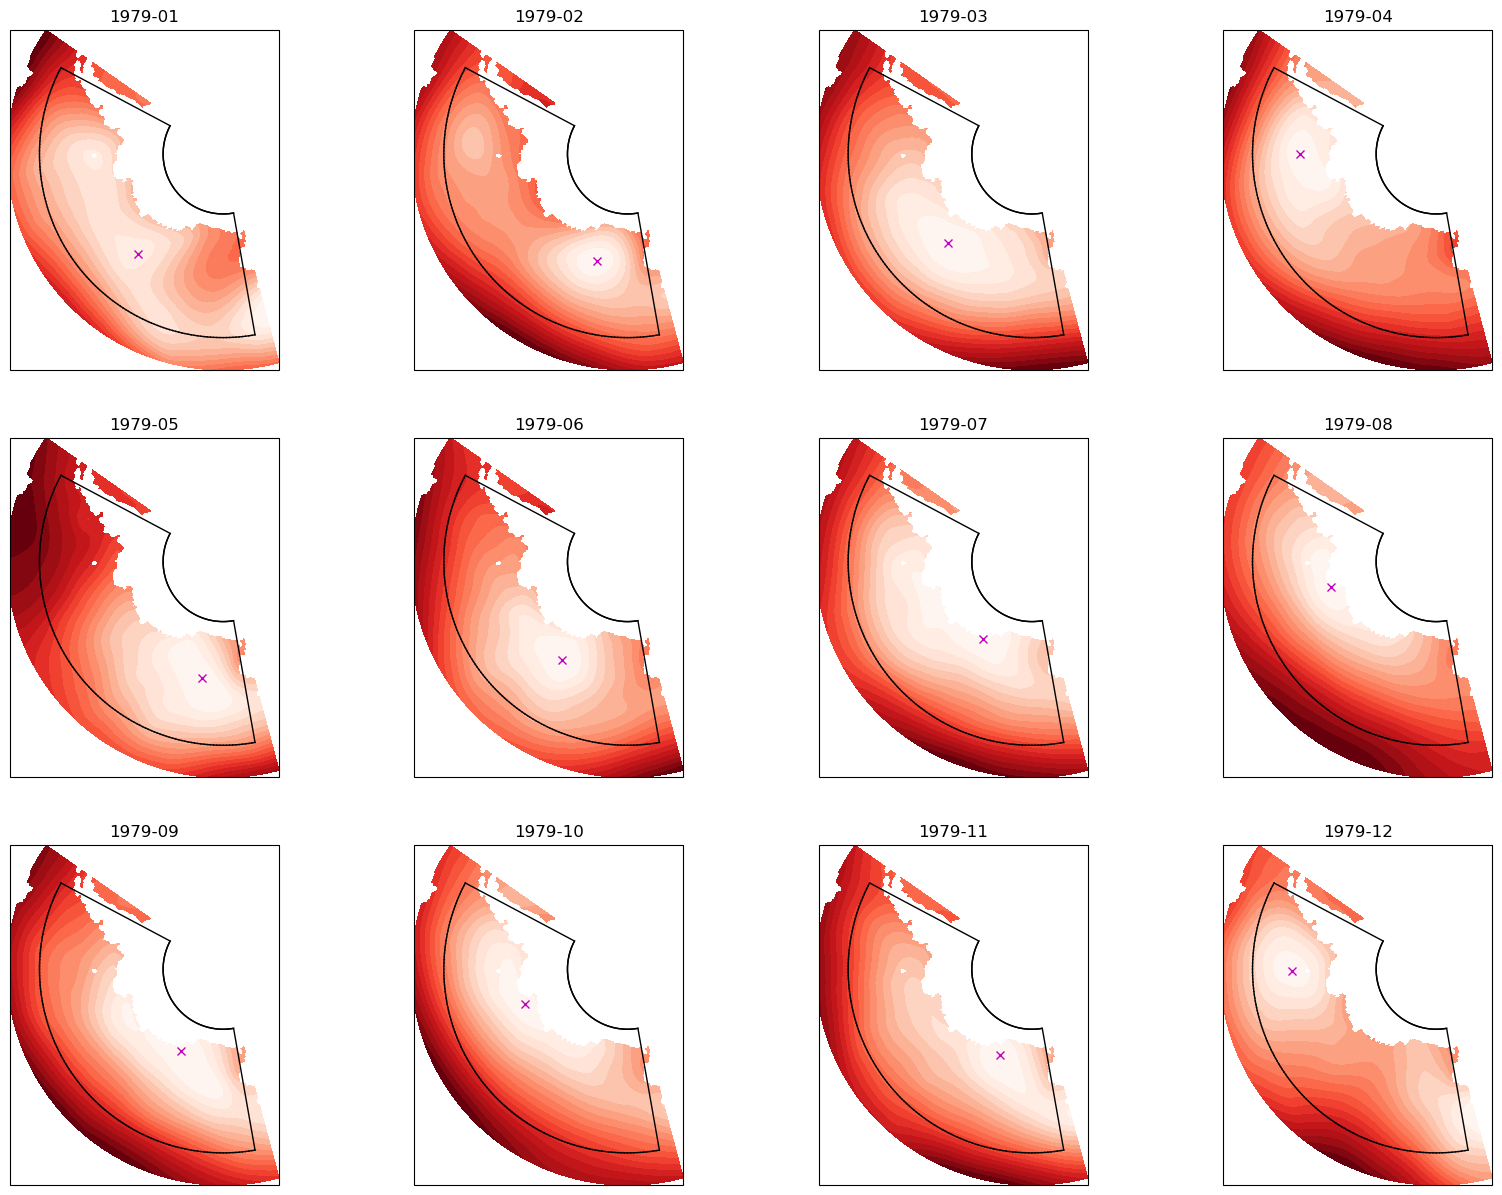

In [15]:
plt.figure(figsize=(20,15))

for i in range(0,12):
    
    da_2D = da_mask.isel(time=i)

    da_2D = da_2D.sel(latitude=slice(-55,-90),longitude=slice(165,305))

    ax = plt.subplot( 3, 4, i+1, 
                        projection=ccrs.Stereographic(central_longitude=0., 
                                                      central_latitude=-90.) )

    ax.set_extent([165,305,-85,-55], ccrs.PlateCarree())

    result = da_2D.plot.contourf( 'longitude', 'latitude', cmap='Reds', 
                                    transform=ccrs.PlateCarree(), 
                                    add_colorbar=False, 
                                    levels=np.linspace(np.nanmin(da_2D.values), np.nanmax(da_2D.values), 20) )

    # ax.coastlines(resolution='110m')
    ax.set_title(str(da_2D.time.values)[0:7])

    ## mark ASL
    df2 = asl_df[ asl_df['time'] == str(da_2D.time.values)[0:10]]
    if len(df2) > 0:
        ax.plot(df2['lon'], df2['lat'], 'mx', transform=ccrs.PlateCarree() )
    draw_regional_box(asl_region)

print('')